In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import csv
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from keras.models import load_model
from shapely.geometry import Polygon
import random
import tensorflow as tf
import numpy as np
import threading
import shutil
import os
import math
import csv
import cv2
import time
import shutil
import os
import numpy as np
import scipy.optimize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D,concatenate,Conv2D,BatchNormalization,Activation,Lambda,MaxPooling2D,Dense,Bidirectional
from shapely.geometry import Polygon
import random
import tensorflow as tf
import multiprocessing
import scipy.io as sio
try:
    import queue
except ImportError:
    import Queue as queue

In [3]:
#https://github.com/argman/EAST/blob/master/icdar.py
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [4]:
#https://github.com/argman/EAST/blob/master/icdar.py
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

In [5]:
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

In [6]:
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

In [7]:
def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

In [8]:
resnet = ResNet50(input_shape=(512, 512, 3), weights='imagenet', include_top=False)
tf.keras.backend.clear_session()
x = resnet.get_layer('conv5_block3_out').output

x = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_1')(x)
x = concatenate([x, resnet.get_layer('conv4_block6_out').output], axis=3)
x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)

x = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_2')(x)
x = tf.keras.layers.concatenate([x, resnet.get_layer('conv3_block4_out').output], axis=3)
x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_3')(x)
x = tf.keras.layers.concatenate([x, resnet.get_layer('conv2_block3_out').output], axis=3)
x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)

x = Conv2D(32,kernel_size=3, strides=1,padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)
x = UpSampling2D(size=(4,4),interpolation='bilinear',data_format='channels_last',name='extra')(x)

pred_score_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='pred_score_map',padding='same')(x)
rbox_geo_map = Conv2D(4, (1, 1), activation=tf.nn.sigmoid, name='rbox_geo_map')(x)
rbox_geo_map = Lambda(lambda x: x * 512)(rbox_geo_map)
angle_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='rbox_angle_map')(x)
angle_map = Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
output = concatenate([pred_score_map,rbox_geo_map, angle_map], axis=3, name='pred_map')


model = tf.keras.models.Model(inputs=resnet.input, outputs= output,name='EAST')
for layers in resnet.layers:
  layers.trainable=False  

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
model.load_weights('/content/drive/MyDrive/resnet50_35epochs.h5')

In [10]:
#Building the Convolution Recurrent Neural Network Architecture for text Recognition.
#https://github.com/qjadud1994/CRNN-Keras/blob/master/Model_GRU.py
inputs = tf.keras.layers.Input(name='the_input', shape=(64,128,3), dtype='float32')  

#CONVOLUTION LAYER1
inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
#BATCHNORM
inner = BatchNormalization()(inner)
#ACCTIVATION
inner = Activation('relu')(inner)
#MAXPOOLING1
inner = MaxPooling2D(pool_size=(2, 1), name='max1')(inner)

#CONVOLUTION LAYER2
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  
#BATCHNORM
inner = BatchNormalization()(inner)
#ACTIVATION
inner = Activation('relu')(inner)
#MAXPOOLING2
inner = MaxPooling2D(pool_size=(2, 1), name='max2')(inner)

#CONVOLUTION LAYER3
inner = Conv2D(32, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  
#BATCHNORM
inner = BatchNormalization()(inner)
#ACTIVATION
inner =Activation('relu')(inner)

#CONVOLUTION LAYER4
inner = Conv2D(32, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  
#BATCHNORM
inner = BatchNormalization()(inner)
#ACTIVATION
inner = Activation('relu')(inner)
#MAXPOOLING3
inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)  

#CONVOLUTION LAYER5
inner = Conv2D(32, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  
#BATCHNORM
inner = BatchNormalization()(inner)
#ACTIVATION
inner = Activation('relu')(inner)

#CONVOLUTION LAYER6
inner = Conv2D(32, (3, 3), padding='same', name='conv6')(inner) 
#BATCHNORM  
inner = BatchNormalization()(inner)
#ACTIVATION
inner =Activation('relu')(inner)
#MAXPOOLING4
inner = MaxPooling2D(pool_size=(2, 1), name='max4')(inner)  

#CONVOLUTION LAYER7
inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='conv7')(inner) 
#BATCHNORM
inner = BatchNormalization()(inner)
#ACTIVATION
inner = Activation('relu')(inner)
#Reshaping
inner = tf.keras.layers.Reshape(target_shape=((64,512)), name='reshape')(inner)  
#DENSE
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

#Applying bi-directional GRU
out=Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,go_backwards=True))(inner)
out=Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,go_backwards=True))(out)
#DENSE
x=Dense(100)(out)#Here we hve given 100 because vocab size is 99 and 1 extra is for blank symbol
x=tf.keras.activations.softmax(x)
recognizer_model=tf.keras.models.Model(inputs,x)

In [11]:
recognizer_model.load_weights('/content/drive/MyDrive/recoginzer.h5')

In [12]:
#Preparing vocabulary for Text Recognition Branch
CHAR_VECTOR = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(CHAR_VECTOR) 
char_index={}
index_char={}
for i,val in enumerate(CHAR_VECTOR):
  index_char[i+1]=val
  char_index[val]=i+1

In [13]:
#https://github.com/argman/EAST/blob/master/eval.py
def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]

In [14]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union

In [15]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g

In [16]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]

In [17]:
#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [18]:
def Pipeline(img):
  '''This function is main complete pipeline of our Model'''
  start_time=time.time()
  
  #1.Text Detection
  img=cv2.resize(img,(512,512))
  ii=model.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]
  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #2.ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]

  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)
  

  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:
    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
    
    
    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 
    if len(rotateParas) > 0:
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        angle=rotateParas[num][2] 
        img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
        img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
        img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
        img2=cv2.resize(img2,(128,64))
        img2=cv2.detailEnhance(img2)
        ii=recognizer_model.predict(np.expand_dims(img2,axis=0))
        arr=tf.keras.backend.ctc_decode(ii,np.ones((1),'int8')*64,)
        for val in arr[0][0].numpy()[0]:
          if val==-1:
            break
          else:
            text+=index_char[val]
        txt.append(text)
        pts.append(points)
    
    # 4. Labeling detected and Recognized Text in Image  
    for i in range(len(txt)):
      cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=1)
    end_time=time.time()
    print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds")  
    return img,txt    


In [19]:
def show_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im,txt=Pipeline(img)
    ax=plt.figure(figsize=(8,8))
    text=','.join(txt)
    plt.imshow(im)
    print("predicted text:",text)

Time Taken By Pipeline=17.014768600463867 seconds
predicted text: BNE,S.ary,Sooot,BENS


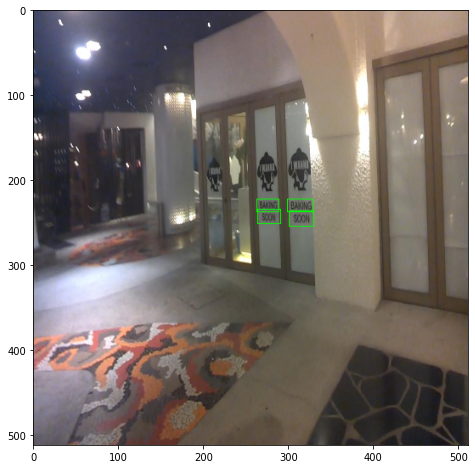

In [20]:
show_image('/content/img_976.jpg')

Time Taken By Pipeline=0.6320829391479492 seconds
predicted text: RAeE:,ees,AEs,nat,Mine,he,FAf,Ar


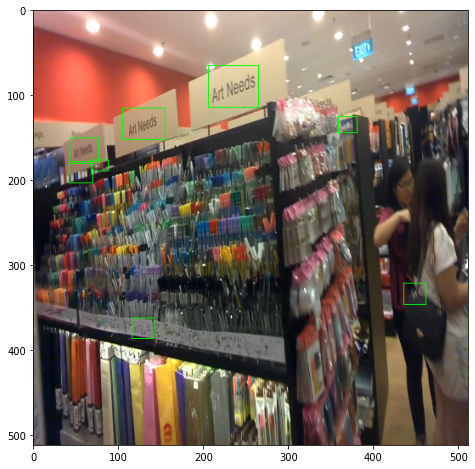

In [21]:
show_image('/content/img_31.jpg')

Time Taken By Pipeline=0.5183267593383789 seconds
predicted text: >oGr,Nirsabsve,ieeef,


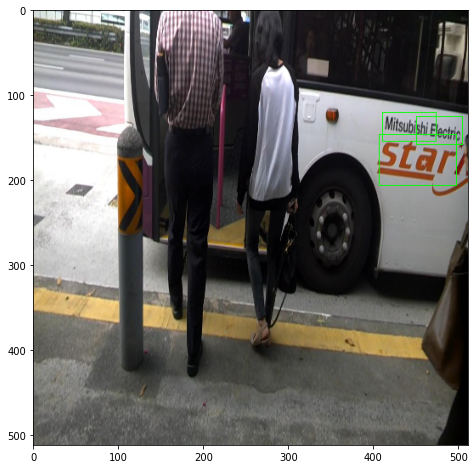

In [22]:
show_image('/content/img_125.jpg')